# Basic Principles

Let's imagine you want to do something slightly more complicated. Maybe you want to make a movie, and include an linked time series plot next to it. Maybe you want to include several movie frames at different cadences. Maybe you want to create your own snazzy custom format. To do so, there are three core concepts you need to understand.

## a `Sequence` is a collection of data, with times

To make an animation, we need a data structure that has some kind of *data* that has a *time* axis associated with it. For example, here we make a `Sequence` out of a small postage stamp of imaging data. 

In [1]:
from playground.tv import *

In [2]:
from playground.cartoons import create_test_stamp
stamp = create_test_stamp(N=10, seed=42)

The `make_sequence` function is a general wrapper that does a decent job of figuring out what kind of sequence should be made out of the given inputs.

In [3]:
seq = make_sequence(stamp)

`make_sequence` should be able to handle at least the following types of input:
    + single FITS filename, and an `ext_image=` keyword for the extension to use
    + list of FITS filenames, and an `ext_image=` keyword
    + a glob pattern to search for FITS files, and an `ext_image=` keyword 
    + single FITS HDUList, and an `ext_image=` keyword 
    + list of loaded FITS HDULists, and an `ext_image=` keyword 
    + a Stamp object from the `cosmics` package

Each `sequence` has a `.time` attribute. It is an `astropy.time` object, and can be indexed as an array. If times are fake (for example, if they are simply image number or cadence number), then we pretend (artificially) that the times are `gps` format with a cadence of 1s. 

In [4]:
print("""
{} 
 has {} times defined,
 spanning {} 
       to {}
 with a cadence of {:.2}""".format(
    seq, len(seq.time), seq.time[0], seq.time[-1], seq.cadence().to('s')))


<stamp-sequence of 10 images> 
 has 10 times defined,
 spanning 2018-01-01 00:00:00.000 
       to 2018-01-01 00:00:18.000
 with a cadence of 2.0 s


Each sequence can be indexed directly with `[i]` to extract the `i`th element of the dataset. Different types of sequences will store data in different ways. For a small stamp, it will generally load the entire 3D (x,y,t) dataset into memory. For a sequence of large FITS images, it will generally only load individual FITS images on the fly as needed, to preserve memory. These different background behaviors should hopefully remain hidden to the casual user.

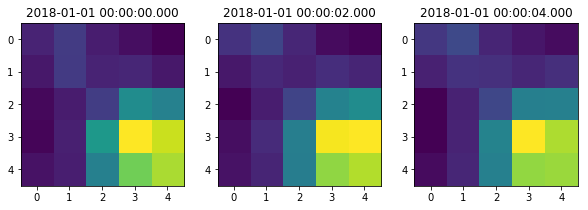

In [5]:
fi, ax = plt.subplots(1,3, figsize=(10,3))
for i in range(3):
    ax[i].imshow(seq[i])
    ax[i].set_title(seq.time[i])

## a `Frame` is a plot panel, which can display a `Sequence`

A frame is a container in which a sequence can be displayed. Different frames can display different views, even of the same dataset. For example, here we create two different frames that include our little sequence `seq` as their data.

In [6]:
normal = imshowFrame(name='cecelia', 
                     data=seq)
normal

<imshow Frame | data=<stamp-sequence of 10 images> | name=cecelia>

Below, we can create a different frame using the same data, but by including the `processingsteps` keyword, it will subtract the mean image from each individual image before displaying it.

In [7]:
subtracted = imshowFrame(name='henrietta', 
                         data=seq, 
                         title='(median subtracted)',
                         processingsteps=['subtractmean'])
subtracted

<imshow Frame | data=<stamp-sequence of 10 images> | name=henrietta>

We will be able to visualize these frames once they are included in an illustration. 

## an `Illustration` is a collection of `Frames`, with its own layout

Once we have created our frames, we can include them in an illustration. The illustration handles not only the basic grid layout of the frames, but also synchronizing their frames when plotting an animation. When you call the illustration's `.plot` method, it will make all the constituent frames `plot` too. When you call the `.animate` method, it will make an animation by looping through a grid of times and updating each frame whenever it needs updating. 

In [ ]:
i = GenericIllustration(imshows=[normal, subtracted])
i.plot()
i.animate('_static/a-pair-of-frames.mp4')

<video src='_static/a-pair-of-frames.mp4' controls loop></video>

Looking back at the `normal` and `subtracted` frames that we defined, we can see a few features. The data and times for the two frames are identical, so the images update synchronously at each timestep of the animation. The `subtracted` frame looks like noise scattered around 0, as we would expect for having subtracted off the mean image. We gave `subtracted` a custom title, but `normal` fell back on an initial best guess.



If you want, you can access the individual frames inside an illustration through the `.frames` dictionary. This may come in handy if you want to modify the attributes of a frame once it's in an illustration, or change something in how it is plotted after calling `i.plot()`. (See examples below.)

In [9]:
print('{} contains {} frames: {})'.format(i, len(i.frames), list(i.frames.keys())))

<I"Generic"> contains 2 frames: ['cecelia', 'henrietta'])


By default, all image frames will share the same color mapping. We can let each frame have its own color mapping by setting the illustration's `sharecolorbar=` keyword to `False`.

In [ ]:
i = GenericIllustration(imshows=[normal, subtracted], sharecolorbar=False)
i.plot()
i.animate('_static/a-pair-of-frames-with-different-colorbars.mp4')

<video src='_static/a-pair-of-frames-with-different-colorbars.mp4' controls loop></video>

If you're trying to directly compare values across different frames, keep `sharecolorbar=True`. If you're looking for qualitative features and want to highlight the details unique to each frame, let each have its own colorbar. In this example, where the data were simulated to represent photon counts, we can see that the noise in the difference images is highest where the flux in the normal image is too.

## some example `Frame` combinations
We can treat frames as somewhat modular containers, and build up illustrations through combinations of them. Here are a couple of examples of making custom illustrations by following the general process of 
 1. make some sequences
 2. put them in frames
 3. fill an illustration


### simple `ZoomFrame` (recreating `illustratefits`)
Let's start by recreating the zoom feature shown with `illustratefits` in the quickstart.

In [ ]:
# first create a sequence
big = make_sequence(create_test_stamp(N=10, xsize=80, ysize=100))

# then define some frames
image = imshowFrame(name='big-image', data=big, title='imshow')
zoom = ZoomFrame(name='zoom', source=image, position=(25, 50), size=(20,10), title='zoom')

# then populate an illustration with them
i = GenericIllustration(imshows=[image, zoom])
i.plot()
#i.animate('_static/an-example-of-a-zoom.mp4', dpi=75)
f = i.frames['big-image']

<video src='_static/an-example-of-a-zoom.mp4' controls loop>An example of a zoom movie.</video>

### multiple `ZoomFrames` on multiple images
Now, let's build a bit on that by including both the original images and some median-subtracted ones. In addition to the extra frames, we're also including some more complicated options in generating the illustration layout.

In [ ]:
# first create a sequence
big = make_sequence(create_test_stamp(N=10, xsize=80, ysize=100))

# then define some frames
image = imshowFrame(name='big-image', data=big, title='imshow')
zoom = ZoomFrame(name='zoom', source=image, position=(25, 50), size=(20,10), title='zoom')
subtracted = imshowFrame(name='big-subtracted', data=big, title='subtracted', processingsteps=['subtractmedian'])
subtractedzoom = ZoomFrame(name='zoom-subtracted', source=subtracted, position=(25, 50), size=(20,10), title='zoom')

# then populate an illustration with them
i = GenericIllustration(imshows=[image, zoom, subtracted, subtractedzoom], imshowrows=2, 
                        figsize=(7,6), hspace=0.2, wspace=0.02, 
                        left=0.05, right=0.95, bottom=0.05, top=0.9)
i.plot()
i.animate('_static/an-example-of-a-more-complicated-zoom.mp4', dpi=75)

<video src='_static/an-example-of-a-more-complicated-zoom.mp4' controls loop>An example of a more complicated zoom movie.</video>

### an `EmptyTimeseriesFrame` linked to an `imshowFrame`

It might be nice to see a light curve synced up to the data from which it is derived. The `EmptyTimeseriesFrame` provides us with an empty frame, into which we can plot some time-series data. Here's a first step toward that capability; it still needs a bit of work, but hopefully this is enough to get started. The basic idea is to create an available plot location (an `Axes` object, in `matplotlib`-speak), where you can fill later with whatever plot elements you like. The below example demonstrates how to populate the time-series frame in two ways, both using its built-in `.plot` function and simply by adding elements to `i.frames['timeseries'].ax`.

In [ ]:
# make a dataset
star = make_sequence(create_test_stamp(N=25, xsize=10, ysize=10, single=True))

# create an empty time-series frame into which we will plot a timeseries
lightcurve = EmptyTimeseriesFrame(name='timeseries')
someimage = imshowFrame(name='image', data=star, title='', plotingredients=['image', 'arrows', 'colorbar'])

# create an illustration that positions these frames next to each other
i = SideBySideIllustration(timeseries=[lightcurve], imshows=[someimage])

# plotting the illustration creates the basic structure...
i.plot()

# ...but we can still modify it through the individual frames
f = i.frames['timeseries']

# the time-series f.plot plot will subtract a the illustration's shared time offset
time = star.time.jd
flux = star._gather_3d().sum(-1).sum(-1)
f.plot(time, flux, marker='o', color='black')

# the f.ax refers to the time-series axes, so this is how we set up to plot into it
plt.sca(f.ax)
plt.axhline(np.mean(flux), color='cornflowerblue', zorder=-1)
plt.ylabel('Some Flux')

i.animate('_static/an-example-of-a-timeseries.mp4')

<video src='_static/an-example-of-a-timeseries.mp4' controls loop>An example movie with a time-series linked to the movie.</video>

The interface for plotting timeseries is still a little buggy and may change soon. For now, hopefully you find this helpful! 

Some more examples are included, in one way or another, in the `tests/` directory of the `playground` repository. Check those out, or please feel free to contribute new examples here! As always, please do not hesitate to contact [Zach Berta-Thompson](zach.bertathompson@colorado.edu) or leave an issue on the [gitlab repository](http://tessgit.mit.edu/zkbt/playground).